## Neural Part Of Speech Tagging

We're now going to solve the same problem of POS tagging with neural networks.
<img src=https://i.stack.imgur.com/6pdIT.png width=320>

From deep learning perspective, this is a task of predicting a sequence of outputs aligned to a sequence of inputs. There are several problems that match this formulation:
* Part Of Speech Tagging -  an auxuliary task for many NLP problems
* Named Entity Recognition - for chat bots and web crawlers
* Protein structure prediction - for bioinformatics

In [1]:
from tensorboard.plugins.hparams import api as hp
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
import nltk
import sys
import numpy as np
import os, datetime
from IPython.display import HTML, display
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
import keras
import keras.layers as L
from keras.utils.np_utils import to_categorical
from keras_contrib.losses import crf_loss
from keras_contrib.layers import CRF
import tensorflow as tf


In [2]:
nltk.download('brown')
# The Brown Corpus was the first million-word electronic corpus of English, created in 1961 at Brown University.
nltk.download('universal_tagset')
"""
'universal_tagset' - это набор тэгов для частей речи из 12 позиций
VERB - verbs (all tenses and modes)
NOUN - nouns (common and proper)
PRON - pronouns 
ADJ - adjectives
ADV - adverbs
ADP - adpositions (prepositions and postpositions)
CONJ - conjunctions
DET - determiners
NUM - cardinal numbers
PRT - particles or other function words
X - other: foreign words, typos, abbreviations
. - punctuation
"""
# Теперь каждому слову из предложеий data ставим в соответствие тэг
data = nltk.corpus.brown.tagged_sents(tagset='universal')
all_tags = ['#EOS#','#UNK#','ADV', 'NOUN', 'ADP', 'PRON', 'DET', '.', 'PRT', 'VERB', 'X', 'NUM', 'CONJ', 'ADJ']
# и переводим все  внижний регистр
data = np.array([ [(word.lower(),tag) for word,tag in sentence] for sentence in data ])

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
C:\Users\Asus\AppData\Local\Temp/ipykernel_19284/2680082382.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array([ [(word.lower(),tag) for word,tag in sentence] for sentence in data ])


In [3]:
train_data, test_data = train_test_split(data,test_size=0.25,random_state=42)

In [4]:
# Задаем каталог для хранения логов
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [5]:
# Удаляем старые логи
!rm -rf f'{log_dir}

"rm" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [6]:
def draw(sentence):
    """
    Выводит часть речи над каждым словом в предложении
    """
    words,tags = zip(*sentence)
    display(HTML('<table><tr>{tags}</tr>{words}<tr></table>'.format(
                words = '<td>{}</td>'.format('</td><td>'.join(words)),
                tags = '<td>{}</td>'.format('</td><td>'.join(tags)))))
    
    
draw(data[11])
draw(data[10])
draw(data[7])

NOUN,ADP,NOUN,NOUN,NOUN,NOUN,VERB,ADV,VERB,ADP,DET,ADJ,NOUN,.,implementation,of,georgia's,automobile,title,law,was,also,recommended,by,the,outgoing,jury,.


PRON,VERB,ADP,DET,NOUN,.,VERB,NOUN,PRT,VERB,.,DET,NOUN,.,it,urged,that,the,city,``,take,steps,to,remedy,'',this,problem,.


NOUN,VERB,merger,proposed


### Создание словарей

Как и раньше, нам нужно построить отображение токенов на целочисленные идентификаторы. На этот раз наша модель работает на уровне слов, обрабатывая одно слово за шаг RNN. Это означает, что нам придется иметь дело с гораздо большим словарным запасом.

К счастью для нас, мы получаем эти слова только в качестве входных данных, то есть нам не нужно их предсказывать. Это означает, что мы можем иметь большой словарный запас бесплатно, используя встраивание слов.

In [7]:
word_counts = Counter()
for sentence in data:
    words,tags = zip(*sentence)
    word_counts.update(words)
# Добавим  втеги еще 2 - '#EOS#' для редко используемых слов и #UNK# для незнакомых и обрежем к-во ключей в словаре до 10000
all_words = ['#EOS#','#UNK#'] + list(list(zip(*word_counts.most_common(10000)))[0])

# давайте измерим, какая часть слов данных находится в словаре
print("Coverage = %.5f" % (float(sum(word_counts[w] for w in all_words)) / sum(word_counts.values())))

Coverage = 0.92876


In [8]:
"""
Класс defaultdict() модуля collections ничем не отличается от обычного словаря за исключением того, 
что по умолчанию всегда вызывается функция, которая возвращает значение по умолчанию для новых значений. 
Другими словами Класс defaultdict() представляет собой словарь со значениями по умолчанию
"""
word_to_id = defaultdict(lambda:1, { word: i for i, word in enumerate(all_words) })
tag_to_id = { tag: i for i, tag in enumerate(all_tags)}

In [9]:
tag_to_id # Это словарь тэгов

{'#EOS#': 0,
 '#UNK#': 1,
 'ADV': 2,
 'NOUN': 3,
 'ADP': 4,
 'PRON': 5,
 'DET': 6,
 '.': 7,
 'PRT': 8,
 'VERB': 9,
 'X': 10,
 'NUM': 11,
 'CONJ': 12,
 'ADJ': 13}

In [10]:
word_to_id # словарь из слов, упорядоченных по возрастанию их использование

defaultdict(<function __main__.<lambda>()>,
            {'#EOS#': 0,
             '#UNK#': 1,
             'the': 2,
             ',': 3,
             '.': 4,
             'of': 5,
             'and': 6,
             'to': 7,
             'a': 8,
             'in': 9,
             'that': 10,
             'is': 11,
             'was': 12,
             'he': 13,
             'for': 14,
             '``': 15,
             "''": 16,
             'it': 17,
             'with': 18,
             'as': 19,
             'his': 20,
             'on': 21,
             'be': 22,
             ';': 23,
             'at': 24,
             'by': 25,
             'i': 26,
             'this': 27,
             'had': 28,
             '?': 29,
             'not': 30,
             'are': 31,
             'but': 32,
             'from': 33,
             'or': 34,
             'have': 35,
             'an': 36,
             'they': 37,
             'which': 38,
             '--': 39,
             'one': 40

Преобразуем слова и тэги в  fixed-size matrix

In [11]:
def to_matrix(lines, token_to_id, max_len=None, pad=0, dtype='int32', time_major=False):
    """Converts a list of names into rnn-digestable matrix with paddings added after the end"""
    
    max_len = max_len or max(map(len,lines))
    matrix = np.empty([len(lines), max_len],dtype)
    matrix.fill(pad)

    for i in range(len(lines)):
        line_ix = list(map(token_to_id.__getitem__,lines[i]))[:max_len]
        matrix[i,:len(line_ix)] = line_ix

    return matrix.T if time_major else matrix



In [12]:
batch_words, batch_tags = zip(*[zip(*sentence) for sentence in data[-3:]])

print("Word ids:")
print(to_matrix(batch_words, word_to_id))
print("Tag ids:")
print(to_matrix(batch_tags, tag_to_id))

Word ids:
[[   2 3057    5    2 2238 1334 4238 2454    3    6   19   26 1070   69
     8 2088    6    3    1    3  266   65  342    2    1    3    2  315
     1    9   87  216 3322   69 1558    4    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [  45   12    8  511 8419    6   60 3246   39    2    1    1    3    2
   845    1    3    1    3   10 9910    2    1 3470    9   43    1    1
     3    6    2 1046  385   73 4562    3    9    2    1    1 3250    3
    12   10    2  861 5240   12    8 8936  121    1    4]
 [  33   64   26   12  445    7 7346    9    8 3337    3    1 2811    3
     2  463  572    2    1    1 1649   12    1    4    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]
Tag ids:
[[ 6  3  4  6  3  3  9  9  7 12  4  5  9  4  6  3 12  7  9  7  9  8  4  6
   3  7  6 13  3  4  6  3  9  4  3  7  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0

### Build model

Unlike our previous lab, this time we'll focus on a high-level keras interface to recurrent neural networks. It is as simple as you can get with RNN, allbeit somewhat constraining for complex tasks like seq2seq.

By default, all keras RNNs apply to a whole sequence of inputs and produce a sequence of hidden states `(return_sequences=True` or just the last hidden state `(return_sequences=False)`. All the recurrence is happening under the hood.

At the top of our model we need to apply a Dense layer to each time-step independently. As of now, by default keras.layers.Dense would apply once to all time-steps concatenated. We use __keras.layers.TimeDistributed__ to modify Dense layer so that it would apply across both batch and time axes.

В отличие от нашей предыдущей работы, на этот раз мы сосредоточимся на высокоуровневом интерфейсе keras для рекуррентных нейронных сетей. Это настолько просто, насколько вы можете получить с помощью RNN, хотя и несколько ограничено для сложных задач, таких как seq2seq.

По умолчанию все RNN keras применяются ко всей последовательности входных данных и создают последовательность скрытых состояний (return_sequences=True или только последнее скрытое состояние (return_sequences=False). Все повторения происходят под капотом.

В верхней части нашей модели нам нужно применить Dense слой к каждому временному шагу независимо. На данный момент keras.layers.Dense по умолчанию применяется один раз ко всем объединенным временным шагам. Мы используем  __keras.layers.TimeDistributed__ для изменения Dense слоя, чтобы он применялся как к пакетной, так и к временной осям.

In [13]:
model = keras.models.Sequential()
model.add(L.InputLayer([None],dtype='int32'))
model.add(L.Embedding(len(all_words),50))
model.add(L.SimpleRNN(64,return_sequences=True))

#add top layer that predicts tag probabilities
stepwise_dense = L.Dense(len(all_tags),activation='softmax')
stepwise_dense = L.TimeDistributed(stepwise_dense)
model.add(stepwise_dense)

__Training:__ in this case we don't want to prepare the whole training dataset in advance. The main cause is that the length of every batch depends on the maximum sentence length within the batch. This leaves us two options: use custom training code as in previous seminar or use generators.

Keras models have a __`model.fit_generator`__ method that accepts a python generator yielding one batch at a time. But first we need to implement such generator:


Обучение: в этом случае мы не хотим заранее готовить весь набор обучающих данных. Основная причина в том, что длина каждого пакета зависит от максимальной длины предложения в пакете. Это оставляет нам два варианта: использовать собственный обучающий код, как на предыдущем семинаре, или использовать генераторы.

В моделях Keras есть метод __`model.fit_generator`__, который принимает генератор Python, выдающий по одному пакету за раз. Но сначала нам нужно реализовать такой генератор:

In [14]:
BATCH_SIZE=32
def generate_batches(sentences,batch_size=BATCH_SIZE,max_len=None,pad=0):
    assert isinstance(sentences,np.ndarray),"Make sure sentences is q numpy array"
    
    while True:
        indices = np.random.permutation(np.arange(len(sentences)))
        for start in range(0,len(indices)-1,batch_size):
            batch_indices = indices[start:start+batch_size]
            batch_words,batch_tags = [],[]
            for sent in sentences[batch_indices]:
                words,tags = zip(*sent)
                batch_words.append(words)
                batch_tags.append(tags)

            batch_words = to_matrix(batch_words,word_to_id,max_len,pad)
            batch_tags = to_matrix(batch_tags,tag_to_id,max_len,pad)

            batch_tags_1hot = to_categorical(batch_tags,len(all_tags)).reshape(batch_tags.shape+(-1,))
            yield batch_words,batch_tags_1hot
        

еще одна вещь, которая нам нужна, — это измерение производительности модели. Сложность заключается не в том, чтобы считать точность после окончания предложения (при заполнении), а в том, чтобы убедиться, что мы считаем все данные проверки ровно один раз.

Хотя нет ничего невозможного в том, чтобы убедить Keras сделать все это, мы можем также написать собственный обратный вызов, который сделает это. Обратные вызовы Keras позволяют вам написать собственный код, который будет запускаться один раз в каждую эпоху или каждый мини-пакет. Мы определим его через LambdaCallback
__Callbacks:__ Another thing we need is to measure model performance. The tricky part is not to count accuracy after sentence ends (on padding) and making sure we count all the validation data exactly once.

While it isn't impossible to persuade Keras to do all of that, we may as well write our own callback that does that.
Keras callbacks allow you to write a custom code to be ran once every epoch or every minibatch. We'll define one via LambdaCallback

In [15]:
def compute_test_accuracy(model):
    test_words,test_tags = zip(*[zip(*sentence) for sentence in test_data])
    test_words,test_tags = to_matrix(test_words,word_to_id),to_matrix(test_tags,tag_to_id)

    #predict tag probabilities of shape [batch,time,n_tags]
    predicted_tag_probabilities = model.predict(test_words,verbose=1)
    predicted_tags = predicted_tag_probabilities.argmax(axis=-1)

    #compute accurary excluding padding
    numerator = np.sum(np.logical_and((predicted_tags == test_tags),(test_words != 0)))
    denominator = np.sum(test_words != 0)
    return float(numerator)/denominator


class EvaluateAccuracy(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs=None):
        sys.stdout.flush()
        print("\nMeasuring validation accuracy...")
        acc = compute_test_accuracy(self.model)
        print("\nValidation accuracy: %.5f\n"%acc)
        sys.stdout.flush()
        

In [16]:
model.compile('adam','categorical_crossentropy')

history = model.fit_generator(generate_batches(train_data),len(train_data)/BATCH_SIZE,
                    callbacks=[EvaluateAccuracy()], epochs=5,)

Epoch 1/5


C:\Users\Asus\AppData\Local\Temp/ipykernel_19284/3694479188.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generate_batches(train_data),len(train_data)/BATCH_SIZE,


1342/1343 [============================>.] - ETA: 0s - loss: 0.2670
Measuring validation accuracy...
448/448 [==============================] - 6s 13ms/step

Validation accuracy: 0.94040

1343/1343 [==============================] - 28s 19ms/step - loss: 0.2667
Epoch 2/5
1342/1343 [============================>.] - ETA: 0s - loss: 0.0585
Measuring validation accuracy...
448/448 [==============================] - 5s 12ms/step

Validation accuracy: 0.94404

1343/1343 [==============================] - 24s 18ms/step - loss: 0.0585
Epoch 3/5
1342/1343 [============================>.] - ETA: 0s - loss: 0.0515
Measuring validation accuracy...
448/448 [==============================] - 5s 12ms/step

Validation accuracy: 0.94517

1343/1343 [==============================] - 26s 20ms/step - loss: 0.0515
Epoch 4/5
1341/1343 [============================>.] - ETA: 0s - loss: 0.0474
Measuring validation accuracy...
448/448 [==============================] - 5s 12ms/step

Validation accuracy: 0.945

{'loss': [0.2667122781276703, 0.05853678658604622, 0.05151652172207832, 0.04735688865184784, 0.04276196286082268]}


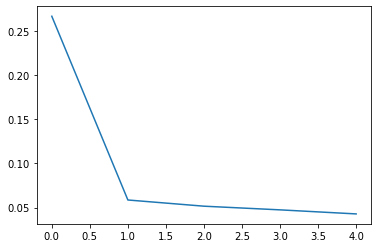

In [17]:
import matplotlib.pyplot as plt
print(history.history)
plt.plot(history.history['loss'])

Measure final accuracy on the whole test set.

In [18]:
acc = compute_test_accuracy(model)
print("Final accuracy: %.5f"%acc)

assert acc>0.94, "Keras has gone on a rampage again, please contact course staff."

448/448 [==============================] - 5s 12ms/step
Final accuracy: 0.94421


### Going bidirectional

Since we're analyzing a full sequence, it's legal for us to look into future data.

A simple way to achieve that is to go both directions at once, making a __bidirectional RNN__.

In Keras you can achieve that both manually (using two LSTMs and Concatenate) and by using __`keras.layers.Bidirectional`__. 

This one works just as `TimeDistributed` we saw before: you wrap it around a recurrent layer (SimpleRNN now and LSTM/GRU later) and it actually creates two layers under the hood.

Your first task is to use such a layer our POS-tagger.

Поскольку мы анализируем полную последовательность, мы можем смотреть на будущие данные.

Простой способ добиться этого — двигаться в обоих направлениях одновременно, создавая двунаправленную RNN.

В Keras вы можете добиться этого как вручную (используя два LSTM и Concatenate), так и используя keras.layers.Bidirectional.

Он работает так же, как TimeDistributed, который мы видели раньше: вы оборачиваете его вокруг рекуррентного слоя (сейчас SimpleRNN, а позже LSTM/GRU), и он фактически создает два слоя под капотом.

Ваша первая задача — использовать такой слой, как наш POS-тегер.

In [19]:
# Создадим модель с  bidirectional SimpleRNN
model = keras.models.Sequential()
model.add(L.InputLayer([None],dtype='int32'))
model.add(L.Embedding(len(all_words),50))
model.add(L.Bidirectional(L.SimpleRNN(64, return_sequences=True)))
# add top layer that predicts tag probabilities
stepwise_dense = L.Dense(len(all_tags),activation='softmax')
stepwise_dense = L.TimeDistributed(stepwise_dense)
model.add(stepwise_dense)

In [20]:
model.compile('adam','categorical_crossentropy')
model.fit_generator(generate_batches(train_data),len(train_data)/BATCH_SIZE,
                    callbacks=[EvaluateAccuracy()], epochs=5,)

Epoch 1/5


C:\Users\Asus\AppData\Local\Temp/ipykernel_19284/2198750851.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generate_batches(train_data),len(train_data)/BATCH_SIZE,


1343/1343 [============================>.] - ETA: 0s - loss: 0.2066
Measuring validation accuracy...
448/448 [==============================] - 9s 20ms/step

Validation accuracy: 0.95579

1343/1343 [==============================] - 43s 31ms/step - loss: 0.2065
Epoch 2/5
1343/1343 [============================>.] - ETA: 0s - loss: 0.0428
Measuring validation accuracy...
448/448 [==============================] - 9s 21ms/step

Validation accuracy: 0.96049

1343/1343 [==============================] - 44s 33ms/step - loss: 0.0428
Epoch 3/5
1342/1343 [============================>.] - ETA: 0s - loss: 0.0350
Measuring validation accuracy...
448/448 [==============================] - 10s 22ms/step

Validation accuracy: 0.96237

1343/1343 [==============================] - 48s 36ms/step - loss: 0.0350
Epoch 4/5
1344/1343 [==============================] - ETA: 0s - loss: 0.0295
Measuring validation accuracy...
448/448 [==============================] - 10s 21ms/step

Validation accuracy: 0.9

In [21]:
acc = compute_test_accuracy(model)
print("\nFinal accuracy: %.5f"%acc)

assert acc>0.96, "Bidirectional RNNs are better than this!"
print("Well done!")

448/448 [==============================] - 10s 22ms/step

Final accuracy: 0.96113
Well done!


Task I: Structured loss functions (more bonus points) Структурированные функции потерь

Since we're tagging the whole sequence at once, we might as well train our network to do so. Remember linear CRF from the lecture? You can also use it as a loss function for your RNN

Поскольку мы помечаем всю последовательность сразу, мы могли бы также научить нашу сеть делать это. Помните линейную CRF из лекции? Вы также можете использовать его как функцию потерь для вашей RNN.

  * Есть несколько способов сделать это, но мы рекомендуем начать с [Conditional Random Fields](http://blog.echen.me/2012/01/03/introduction-to-conditional-random-fields/)
  * You can plug CRF as a loss function and still train by backprop. There's even some neat tensorflow [implementation](https://www.tensorflow.org/addons/api_docs/python/tfa/layers/CRF) for you.
  Вы можете подключить CRF как функцию потерь и по-прежнему тренироваться с помощью обратного распространения. 
  * Alternatively, you can condition your model on previous tags (make it autoregressive) and perform __beam search__ over that model.
  
Кроме того, вы можете обусловить свою модель предыдущими тегами (сделать ее авторегрессивной) и выполнить

In [22]:
#Define a model that utilizes bidirectional SimpleRNN
model = keras.models.Sequential()

model.add(L.InputLayer([None],dtype='int32'))
model.add(L.Embedding(len(all_words),50))
model.add(L.Bidirectional(L.GRU(128,return_sequences=True,activation='relu')))
model.add(L.Dropout(0.5))
model.add(L.Bidirectional(L.GRU(64,return_sequences=True,activation='relu')))
model.add(L.Dropout(0.5))

#add top layer that predicts tag probabilities
stepwise_dense = L.Dense(len(all_tags),activation='softmax')
stepwise_dense = L.TimeDistributed(stepwise_dense)
model.add(stepwise_dense)

In [23]:
#feel free to change anything here
adam = keras.optimizers.Adam(clipnorm=1.2)
model.compile(adam,'categorical_crossentropy')

model.fit_generator(generate_batches(train_data),len(train_data)/BATCH_SIZE,
                    callbacks=[EvaluateAccuracy()], epochs=5,)

Epoch 1/5


C:\Users\Asus\AppData\Local\Temp/ipykernel_19284/2696369520.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generate_batches(train_data),len(train_data)/BATCH_SIZE,


1344/1343 [==============================] - ETA: 0s - loss: 0.1930
Measuring validation accuracy...
448/448 [==============================] - 51s 114ms/step

Validation accuracy: 0.95642

1343/1343 [==============================] - 243s 177ms/step - loss: 0.1930
Epoch 2/5
1344/1343 [==============================] - ETA: 0s - loss: 0.0518
Measuring validation accuracy...
448/448 [==============================] - 45s 101ms/step

Validation accuracy: 0.96195

1343/1343 [==============================] - 233s 173ms/step - loss: 0.0518
Epoch 3/5
1344/1343 [==============================] - ETA: 0s - loss: 0.0438
Measuring validation accuracy...
448/448 [==============================] - 51s 113ms/step

Validation accuracy: 0.96444

1343/1343 [==============================] - 225s 167ms/step - loss: 0.0438
Epoch 4/5
1344/1343 [==============================] - ETA: 0s - loss: 0.0391
Measuring validation accuracy...
448/448 [==============================] - 54s 122ms/step

Validation a

In [24]:
BATCH_SIZE = 256
model.fit_generator(generate_batches(train_data),len(train_data)/BATCH_SIZE,
                    callbacks=[EvaluateAccuracy()], epochs=2,)

Epoch 1/2
  1/167 [..............................] - ETA: 21s - loss: 0.0268

C:\Users\Asus\AppData\Local\Temp/ipykernel_19284/1797685126.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generate_batches(train_data),len(train_data)/BATCH_SIZE,


168/167 [==============================] - ETA: 0s - loss: 0.0337
Measuring validation accuracy...
448/448 [==============================] - 59s 131ms/step

Validation accuracy: 0.96684

167/167 [==============================] - 85s 505ms/step - loss: 0.0337
Epoch 2/2
168/167 [==============================] - ETA: 0s - loss: 0.0327
Measuring validation accuracy...
448/448 [==============================] - 66s 147ms/step

Validation accuracy: 0.96683

167/167 [==============================] - 93s 555ms/step - loss: 0.0327


In [25]:
acc = compute_test_accuracy(model)
print("\nFinal accuracy: %.5f"%acc)

448/448 [==============================] - 64s 144ms/step

Final accuracy: 0.96683
